In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from random import choice

### Pré-processamento dos ECG's

#### Labels

In [2]:
LABELS_FOLDER = "../dataset/labels"

ecgsAcceptable = []

with open(os.path.join(LABELS_FOLDER, "RECORDS-acceptable")) as file:
    ecgsAcceptable = file.readlines()

ecgsAcceptable = map(
    lambda ecg: ecg[:-1], 
    ecgsAcceptable
)
ecgsAcceptable = list(ecgsAcceptable)

In [3]:
print(f"{ len(ecgsAcceptable) / 10 }% is acceptable")

77.3% is acceptable


#### ECG Summary

In [4]:
DATASET_FOLDER = "../dataset/set-a"

ecgs = os.listdir(DATASET_FOLDER) 
ecgs = filter(lambda ecg: ".txt" in ecg, ecgs)
ecgs = list(ecgs)

columns = [
    "amostra",
    "lead I", 
    "lead II", 
    "lead III", 
    "aVR", 
    "aVL",
    "aVF", 
    "V1",
    "V2",
    "V3",
    "V4",
    "V5",
    "V6"
]

ecgSummary = pd.DataFrame(
    columns = [
        "id", 
        "mean", 
        "median", 
        "std", 
        "variance", 
        "skew", 
        "kurtosis", 
        "snr", 
        "max", 
        "min", 
        "isAcceptable"
    ]
)

targetDerivation = "lead I"

for ecg in ecgs: 
    ecgDf = pd.read_csv(
        os.path.join(DATASET_FOLDER, ecg)
    )
    ecgDf.columns = columns

    id = ecg.split(".").pop(0)

    derivation = ecgDf[targetDerivation]

    mean = derivation.mean()
    median = derivation.median()
    std = derivation.std()
    variance = derivation.var()
    skew = derivation.skew()
    kurtosis = derivation.kurtosis()
    
    snr = 0
    if std != 0:
        snr = mean / std

    max = derivation.max()
    min = derivation.min()

    isAcceptable = "V" if id in ecgsAcceptable else "F"

    ecgSummary.loc[len(ecgSummary)] = [
        id, 
        mean, 
        median, 
        std, 
        variance, 
        skew, 
        kurtosis, 
        snr, 
        max, 
        min, 
        isAcceptable
    ]

In [5]:
print(ecgSummary.shape)
ecgSummary.sample(12)

(1000, 11)


,id,mean,median,std,variance,skew,kurtosis,snr,max,min,isAcceptable
890,1607439,0.698940,-1.0,18.702981,349.801501,-0.037283,-0.096879,0.037371,52,-53,F
601,1636043,2.509502,0.0,15.389964,236.851000,0.841681,1.140047,0.163061,58,-48,V
611,2436056,2.473095,1.0,25.663692,658.625076,1.287864,5.437945,0.096366,180,-75,V
818,2855979,3.694539,-1.0,20.530356,421.495510,3.203584,13.981952,0.179955,136,-47,V
7,2220284,1.104421,0.0,12.722163,161.853440,2.736280,12.870531,0.086811,90,-30,V
69,2116010,1.223445,-4.0,18.297175,334.786597,3.017648,14.306239,0.066865,139,-44,V
120,1620867,0.357672,-4.0,32.806252,1076.250197,3.235265,16.743353,0.010903,236,-94,V
368,1398947,1.261652,-2.0,44.142163,1948.530564,3.216725,16.124318,0.028582,297,-109,V
775,1583812,2.543709,-4.0,23.677024,560.601481,3.109964,13.242394,0.107434,146,-31,V
872,1315318,1.068414,-7.0,31.958346,1021.335855,4.288882,19.950563,0.033431,207,-34,V


### Datasets para treino e validação

In [5]:
labelsGroups = ecgSummary.groupby("isAcceptable")

ecgAcceptable = labelsGroups.get_group("V")
ecgUnacceptable = labelsGroups.get_group("F")

validationLen = int(0.3 * len(ecgSummary))

ecgsValidation = ecgSummary.sample(validationLen)
ecgsValidation.head()

acceptableCount = ecgsValidation["isAcceptable"]\
    .loc[ecgsValidation["isAcceptable"] == "V"]\
    .count()

unacceptableCount = validationLen - acceptableCount

acceptablePercent = acceptableCount * 100 / validationLen
unacceptablePercent = unacceptableCount * 100 / validationLen

acceptablePercent = round(acceptablePercent, 2)
unacceptablePercent = round(unacceptablePercent, 2)

print(f"Acceptable: { acceptablePercent }%")
print(f"Unacceptable: { unacceptablePercent }%")


Acceptable: 72.67%
Unacceptable: 27.33%


### Exploração dos Datasets

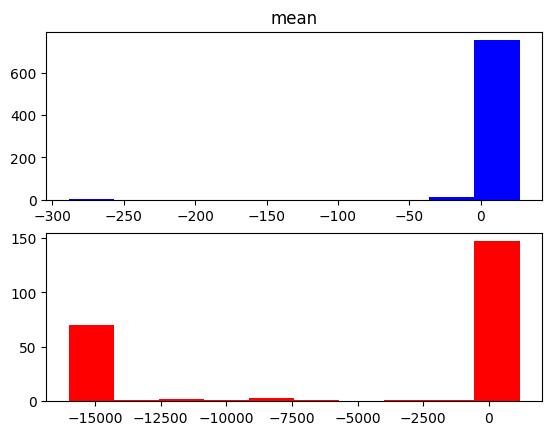

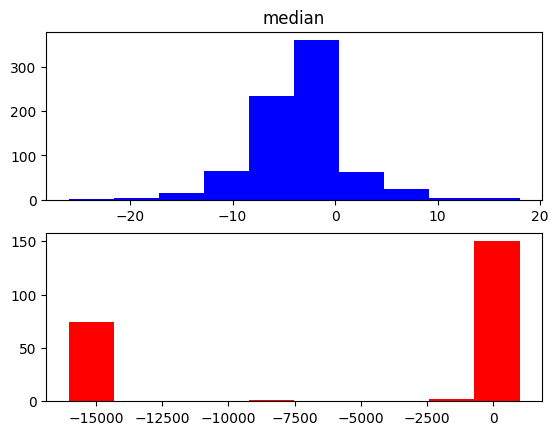

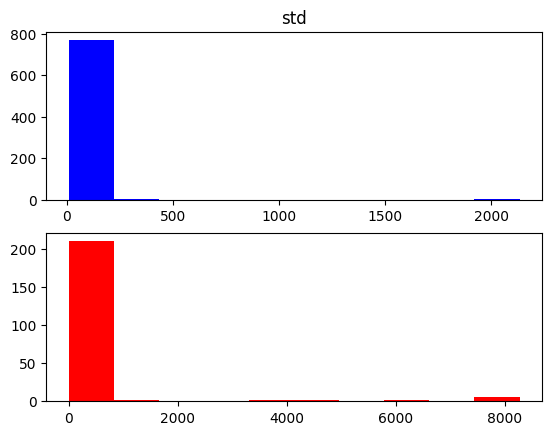

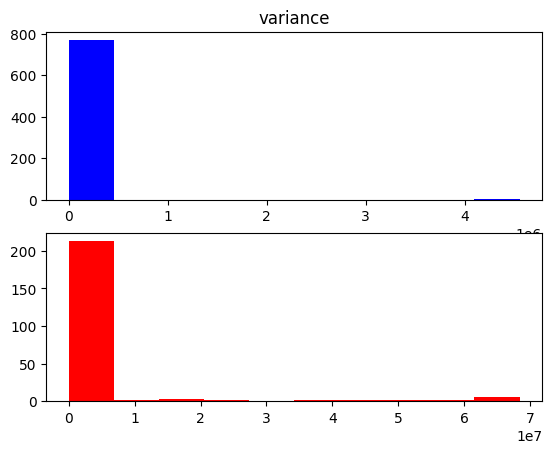

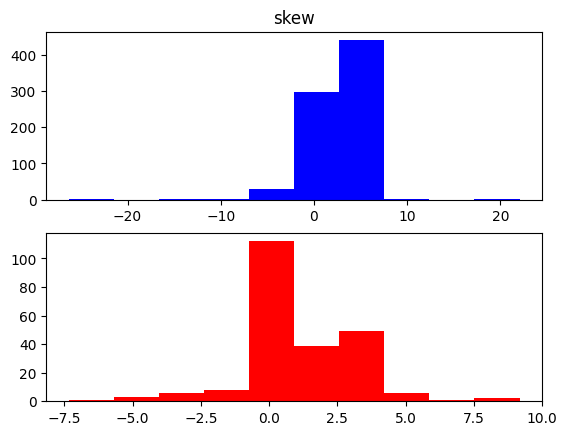

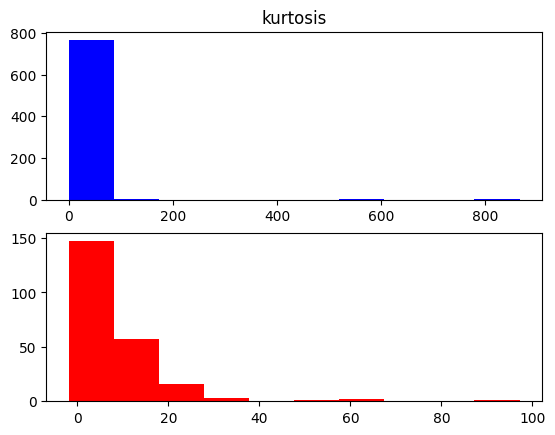

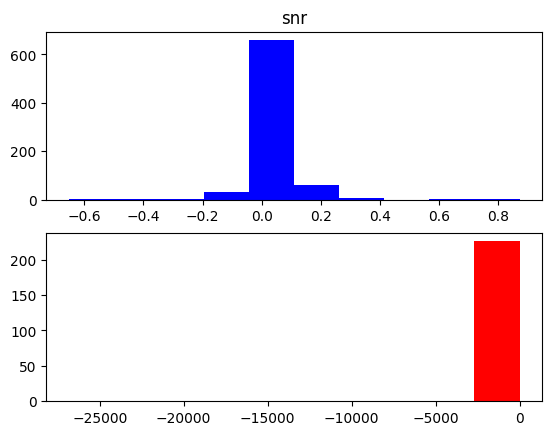

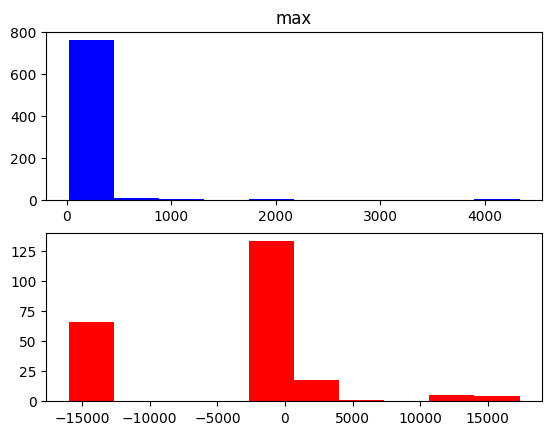

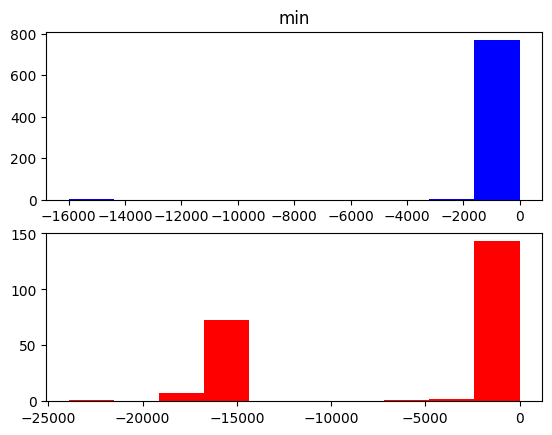

In [53]:
def plotHist(prop, ecgAcceptable, ecgUnacceptable):
    plt.subplot(2, 1, 1)
    plt.hist(ecgAcceptable[prop], color = "blue")
    
    plt.title(prop)
    plt.subplot(2, 1, 2)
    plt.hist(ecgUnacceptable[prop], color = "red")

    plt.show()

for prop in ecgSummary.columns[1:10]:
    plotHist(prop, ecgAcceptable, ecgUnacceptable)

### Modelos de Classificação

In [7]:
class PredictModel():
    def __init__(self, name: str):
        self.name = name

    def learn(self, ecgs: pd.DataFrame):
        raise NotImplementedError()

    def predict(self, ecg: pd.DataFrame):
        raise NotImplementedError()

#### Random

In [8]:
class RandomModel(PredictModel):
    def __init__(self):
        super().__init__("Random")

    def learn(self, ecgs: pd.DataFrame):
        pass

    def predict(self, ecg: pd.DataFrame):
        return choice([ "V", "F" ])    

#### Flatline

In [9]:
class FlatlineModel(PredictModel):
    def __init__(self, threshold):
        super().__init__("Flatline")
        self.threshold = threshold

    def learn(self, ecgs: pd.DataFrame):
        pass

    def predict(self, ecgSumarry: pd.DataFrame):
        id = ecgSumarry["id"]

        ecgFilename = os.path.join(
            DATASET_FOLDER, 
            f"{ id}.txt"
        )

        ecg = pd.read_csv(ecgFilename)
        ecg.columns = columns

        derivate = np.diff(ecg[targetDerivation])
        derivateAbs = np.abs(derivate)

        if np.mean(derivateAbs) <= self.threshold:
            return "F"
        return "V"


#### Difference

In [45]:
class DifferenceModel(PredictModel):
    def __init__(self, threshold):
        super().__init__("Difference")
        self.threshold = threshold

    def learn(self, ecgs: pd.DataFrame):
        pass

    def predict(self, ecgSumarry: pd.DataFrame):
        id = ecgSumarry["id"]

        ecgFilename = os.path.join(
            DATASET_FOLDER, 
            f"{ id}.txt"
        )

        ecg = pd.read_csv(ecgFilename)
        ecg.columns = columns

        leadI = ecg["lead I"]
        leadII = ecg["lead II"]
        leadIII = ecg["lead III"]
        aVR = ecg["aVR"]
        aVL = ecg["aVL"]
        aVF = ecg["aVF"]

        differences = [
            leadI - leadII,
            leadI - leadIII,
            leadI - aVR,
            leadI - aVL,
            leadI - aVF
        ]

        differencesAbs = map(np.abs, differences)
        differencesMean = map(np.mean, differencesAbs)
        differencesThreshold = map(
            lambda mean: mean <= self.threshold, 
            differencesMean
        )

        if all(differencesThreshold): 
            return "V"
        return "F"

### Avaliação de Modelos    

#### Avaliador

In [29]:
class Evaluator():
    def __init__(self, model: PredictModel):
        self.model = model
        self.results = pd.DataFrame(
            columns = [
                "id", 
                "predict", 
                "correct"
            ]
        )

        self.TP = 0 
        self.FN = 0
        self.FP = 0
        self.TN = 0

        self.accuracy = 0
        self.precision = 0
        self.sensitivity = 0
        self.f1Score = 0

    def getResults(self, ecgs: pd.DataFrame):
        self.results = pd.DataFrame(
            columns = [
                "id", 
                "predict", 
                "correct"
            ]
        )
        
        for _, ecg in ecgs.iterrows():
            labelPredicted = self.model.predict(ecg)
            
            self.results.loc[len(self.results)] = [
                ecg["id"],
                labelPredicted,
                ecg["isAcceptable"]
            ]


    def evaluate(self, ecgs: pd.DataFrame): 
        self.getResults(ecgs)

        self.TP = 0 
        self.FN = 0
        self.FP = 0
        self.TN = 0

        for _, result in self.results.iterrows():
            predict = result["predict"]
            correct = result["correct"]

            if correct == "V" and predict == "V":
                self.TP += 1

            if correct == "F" and predict == "V":
                self.FP += 1

            if correct == "V" and predict == "F":
                self.FN += 1

            if correct == "F" and predict == "F":
                self.TN += 1

        self.accuracy = (self.TP + self.TN) / (self.TP + self.TN + self.FP + self.FN)
        self.precision = self.TP / (self.TP + self.FP)
        self.sensitivity = self.TP / (self.TP + self.FN)
        self.f1Score = 2 * (self.precision * self.sensitivity) 
        self.f1Score /= (self.precision + self.sensitivity)

    def toString(self):
        accuracy = round(self.accuracy, 2)
        precision = round(self.precision, 2)
        sensitivity = round(self.sensitivity, 2)
        f1Score = round(self.f1Score, 2)

        out = f"--- { self.model.name} ---\n"
        out += f"Acurácia: { accuracy * 100 }%\n"
        out += f"Precisão: { precision * 100 }%\n"
        out += f"Sensibilidade: { sensitivity * 100 }%\n"
        out += f"F1-Score: { f1Score * 100 }%\n"

        return out


#### Avaliações

##### Random

In [30]:
randomModel = RandomModel()
randomModel.learn(None)

evaluator = Evaluator(randomModel)
evaluator.evaluate(ecgsValidation)

print(evaluator.toString())

--- Random ---
Acurácia: 49.0%
Precisão: 72.0%
Sensibilidade: 50.0%
F1-Score: 59.0%



##### Flatline

In [61]:
flatlineModel = FlatlineModel(.1)
flatlineModel.learn(None)

evaluator = Evaluator(flatlineModel)
evaluator.evaluate(ecgsValidation)

print(evaluator.toString())

--- Flatline ---
Acurácia: 81.0%
Precisão: 80.0%
Sensibilidade: 100.0%
F1-Score: 89.0%



##### Difference

In [58]:
differenceModel = DifferenceModel(80)
differenceModel.learn(None)

evaluator = Evaluator(differenceModel)
evaluator.evaluate(ecgsValidation)

print(evaluator.toString())

--- Difference ---
Acurácia: 84.0%
Precisão: 83.0%
Sensibilidade: 98.0%
F1-Score: 90.0%

